In [119]:
from d2l import torch as d2l
from torch import nn
import numpy as np

#### 8.1.2 Ví dụ
- Sau khi đề cập về lý thuyết, giờ ta sẽ thử lập trình minh họa. Đầu tiên, ta khởi tạo một vài dữ liệu như sau. Để đơn giản, ta tạo chuỗi thời gian bằng cách sử dụng hàm sin cộng thêm một chút nhiễu.

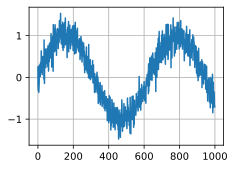

In [120]:
T = 1000 # Generate a total of 1000 points
time = np.arange(0, T)
x = np.sin(0.01 * time) + 0.2 * np.random.normal(size = T)
d2l.plot(time, [x])

- Tiếp theo ta cần biến đổi chuỗi thời gian này thành các đặc trưng và nhãn được sử dụng để huấn luyện mạng. Dựa tren kích thước embedding τ, ta ánh xạ dữ liệu thành các cặp . 

- Ta sẽ mất τ điểm dữ liệu đầu tiên bởi vì ta không có đủ τ điểm dữ liệu trong quá khứ để làm đặc trưng cho chúng. 
- Một cách để khắc phục điều này khi chuỗi thời gian rất dài là loại bỏ đi số ít các phần tử đó. Một cách khác là đệm thêm giá trị 0 vào chuỗi thời gian.
- Ta sử dụng kiến trúc đơn giản với vài tầng kết nối đầy đủ, hàm kích hoạt ReLU và hàm mất mát l2. 

In [121]:
from torch.utils.data import TensorDataset, DataLoader

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(10),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
    def forward(self, X):
        return self.net(X)

def get_data_loader(X, y, batch_size):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch

tau = 4
# Có tổng cộng T - tau dữ liệu với số lượng thuộc tính là tau
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]

# features: | x[tau - 4], x[tau - 3], x[tau - 2], x[tau - 1] | -> x[tau - 1] (do x đánh số từ 0 nên bắt đầu với chỉ số nhỏ nhất là 0)
#           | x[tau - 3], x[tau - 2], x[tau - 1], x[tau]     | -> x[tau]
#           | ...                                            | 
#           | x[T - 5]  , x[T - 4]  , x[T - 3]  , x[T - 2]   | -> x[T - 1]
# Mặt khác, 
#              tau - 4 = 0
#              tau - 3 = 1
#              tau - 2 = 2
#              tau - 1 = 3
# Tương ứng với i từ 0 -> 3
# Theo cột sẽ bắt đầu từ i đến T - tau - 1 + i với chỉ số cột là i
# Như vậy, slicing sẽ là:
#                           features[:, i] = x[i: T - tau + i]

labels = x[tau:]
labels = d2l.torch.tensor(data = labels).type(dtype = torch.float32)
features = d2l.torch.tensor(data = features).type(dtype = torch.float32)
labels = labels.unsqueeze(1)
# print(labels.shape, features.shape)
batch_size, n_train = 16, 600

train_iter = get_data_loader(features[:n_train], labels[:n_train], batch_size)
test_iter = get_data_loader(features[n_train:], labels[n_train:], batch_size)

net = MLP()

loss = nn.MSELoss()
lr = 0.01
trainer = d2l.torch.optim.Adam(net.parameters(), lr)


In [123]:
def train(net, train_iter, test_iter, num_epochs):
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # print(X.dtype)
            y_hat = net(X)
            l = loss(y_hat, y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
        with d2l.torch.no_grad():
            for X, y in test_iter:
                test_loss = loss(net(X), y)
                break
            print(f"Epoch: {epoch} | MSE Train Loss: {l.detach().numpy()} | MSE Test Loss: {test_loss.detach().numpy()}")
train(net, train_iter, test_iter, 10)
    

Epoch: 0 | MSE Train Loss: 0.04818800091743469 | MSE Test Loss: 0.05012005940079689
Epoch: 1 | MSE Train Loss: 0.023636657744646072 | MSE Test Loss: 0.05673949420452118
Epoch: 2 | MSE Train Loss: 0.11161492764949799 | MSE Test Loss: 0.0898592621088028
Epoch: 3 | MSE Train Loss: 0.04850849136710167 | MSE Test Loss: 0.08648405224084854
Epoch: 4 | MSE Train Loss: 0.06785550713539124 | MSE Test Loss: 0.04088442027568817
Epoch: 5 | MSE Train Loss: 0.04752834886312485 | MSE Test Loss: 0.07170998305082321
Epoch: 6 | MSE Train Loss: 0.06109166517853737 | MSE Test Loss: 0.05471975356340408
Epoch: 7 | MSE Train Loss: 0.052323561161756516 | MSE Test Loss: 0.03980354219675064
Epoch: 8 | MSE Train Loss: 0.04022927209734917 | MSE Test Loss: 0.03487595543265343
Epoch: 9 | MSE Train Loss: 0.058638714253902435 | MSE Test Loss: 0.07445520162582397


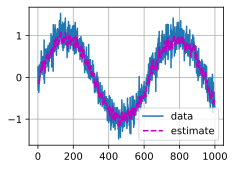

In [124]:
estimate = net(features)
estimate = estimate.detach().numpy()

d2l.plot([time, time[tau:]], [x, estimate],
         legend=['data', 'estimate'])

- Kết quả khá tốt, đúng như những gì ta đã mong đợi, thậm chí sau hơn 600 mẫu quan sát, phép ước lượng vẫn trông khá tin cậy. 
- Nếu ta quan sát dữ liệu tới bước thời gian thứ 600, ta không thể hy vọng sẽ nhận được nhãn gốc cho tất cả các dự đoán tương lai, thay vào đó, ta cần tiến lên từng bước một như thế này:

    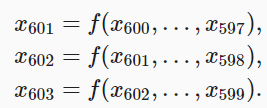

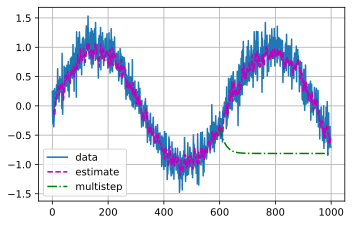

In [125]:
pred = np.zeros(T)
pred[:n_train] = x[:n_train]

for i in range(n_train, T):
    input = pred[(i - tau):i].reshape(1, -1)
    input = torch.from_numpy(input).type(dtype=torch.float32)
    pred[i] = net(input).detach().numpy()

d2l.plot([time, time[tau:], time[n_train:]], 
         [x, estimate, pred[n_train:]], 
         legend = ['data', 'estimate', 'multistep'], figsize = (5.5, 3.5))


Ví dụ trên cho thấy cách này đã thất bại, các giá trị ước lượng nhanh chóng suy giảm về hằng số chỉ sau một vài bước. 
- Tại sao thuật toán này lại hoạt động tệ? 
    + Các sai số dự đoán bị chồng chất qua các bước thời gian. Cụ thể, sau bước thời gian 1 chúng ta nhận được sai số , tiếp theo đầu vào cho bước thời gian 2 bị nhiễu loạn bởi  do đó ta nhận được sai số dự đoán 
    + Sau số có thể phân kỳ khá nhanh khỏi các quan sát đúng. Hiện tượng này khá phổ biến. Ví dụ, dự báo thời tiết trong 24h tới có độ chính xác khá cao nhưng nó giảm đi nhanh chóng với những dự báo xa hơn quãng thời gian đó.